### Installing Necessary Libraries

In [1]:
! pip install pyreadr pandas matplotlib seaborn --quiet

### Importing Neccessary Libraries

In [2]:
import pyreadr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

### LOADING AND PROCESSING DATA

In [3]:
result = pyreadr.read_r("/Users/amarnathreddykalluru/PycharmProjects/Resilience/data/portarthur_sd_df_2019.rdata")
df = result['portarthur_sd_df_2019']
df["origin_census_block_group"] = df["origin_census_block_group"].astype(str)
df["destination_cbg"] = df["destination_cbg"].astype(str)
df["device_count"] = pd.to_numeric(df["device_count"], errors="coerce")
df["destination_device_count"] = pd.to_numeric(df["destination_device_count"], errors="coerce")
df["year"] = df["year"].astype(int)
df["uid"] = df["uid"].astype(int)
df["date"] = pd.to_datetime("2019-01-01") + pd.to_timedelta(df["uid"] - 1, unit="D")

### IN DEGREE Calculation

In [4]:
def cbg_filter(df,cbg):
    return df[df['destination_cbg'] == cbg]
    
def compute_indegree_by_destination(df):
    if len(df['destination_cbg'].unique()) > 1:
        raise Exception("The Dataset has more than one CBG.")
    grouped_indegree_df = df.groupby(["destination_cbg", "date"])["destination_device_count"].sum().reset_index()
    grouped_indegree_df.rename(columns={"destination_device_count": "in_degree"}, inplace=True)
    return grouped_indegree_df

### Smoothing And Normalization

In [5]:
def normalize_data(df):
    df_normalized = df.copy()
    min_val = df["in_degree"].min()
    max_val = df["in_degree"].max()
    df_normalized["in_degree"] = (df_normalized["in_degree"] - min_val) / (max_val - min_val)
    return df_normalized


def smoothen_data(df, SMOOTHING_PERIOD):
    df_smoothed = df.copy()

    df_smoothed["in_degree"] = (
    df["in_degree"]
    .rolling(window=SMOOTHING_PERIOD, center=True, min_periods=1)
    .mean())

    df_smoothed["in_degree"] = (
    df_smoothed["in_degree"]
    .bfill()
    .ffill())

    return df_smoothed
    

### Baseline Value Calculation

In [6]:
def calculate_baseline(df_normalized, disaster_start, BASELINE_DAYS_TO_AVERAGE_BEFORE_DISASTER = 60):

    baseline_start = disaster_start - pd.Timedelta(days=BASELINE_DAYS_TO_AVERAGE_BEFORE_DISASTER)
    baseline_end = disaster_start - pd.Timedelta(days=1)

    baseline_df = df_normalized[
        (df_normalized["date"] >= baseline_start) &
        (df_normalized["date"] <= baseline_end)
    ]

    baseline_value = baseline_df["in_degree"].mean()
    
    return baseline_value

### Calculating t0 (Disaster Start), inactive (Disaster End), tD (Systematic Impact), and t1 (Recovery)

In [13]:
def calculate_start(df, disaster_start):
    t0_row = df[df["date"] == disaster_start]
    if t0_row.empty:
        t0_value = df.loc[df['date'].sub(disaster_start).abs().idxmin()]['in_degree']
        t0 = df.loc[df['date'].sub(disaster_start).abs().idxmin()]['date']
    else:
        t0 = disaster_start
        t0_value = t0_row["in_degree"].iloc[0]
    return t0, t0_value

def calculate_inactive(df, disaster_end):
    inactive_row = df[df["date"] == disaster_end]
    if inactive_row.empty:
        inactive_value = df.loc[df['date'].sub(disaster_end).abs().idxmin()]['in_degree']
        inactive = df.loc[df['date'].sub(disaster_end).abs().idxmin()]['date']
    else:
        inactive = disaster_end
        inactive_value = inactive_row["in_degree"].iloc[0]
    return inactive, inactive_value

def calculate_recovery(df_normalized, disaster_end, baseline_value):

    post_disaster_df = df_normalized[df_normalized["date"] >= disaster_end]

    if post_disaster_df.empty:
        return (disaster_end, 0.0), False

    recovery_df = post_disaster_df[post_disaster_df["in_degree"] >= baseline_value]

    if not recovery_df.empty:
        t1 = recovery_df["date"].iloc[0]
        t1_value = recovery_df["in_degree"].iloc[0]
        recover = True
    else:
        min_point = post_disaster_df["in_degree"].min()
        min_date = post_disaster_df[post_disaster_df["in_degree"] == min_point]["date"].iloc[0]
        tail_df = post_disaster_df[post_disaster_df["date"] >= min_date]
        t1_value = tail_df["in_degree"].max()
        t1 = tail_df[tail_df["in_degree"] == t1_value]["date"].iloc[0]
        if t1 == min_date:
            t1_value = baseline_value
        recover = False

    return (t1, t1_value), recover


def calculate_systematic_impact(df_normalized, baseline_value, t0, t1):
    
    in_recovery_df = df_normalized[(df_normalized["date"] >= t0) & (df_normalized["date"] <= t1)]
    tD_value = in_recovery_df["in_degree"].min()

    if(tD_value >= baseline_value):
        raise Exception("The mobility never went down the baseline during disaster. Abnormal pattern.")
    
    tD = in_recovery_df[in_recovery_df["in_degree"] == tD_value]["date"].iloc[0]
    tD = pd.to_datetime(tD)

    if(tD == t0):
        raise Exception("The mobility went up during disaster. Abnormal pattern")
    
    return (tD, tD_value)

### Defining some math Utils

In [8]:
def calculate_slope(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    if x1 == x2:
        return 0
    else:
        slope = (y2 - y1) / (x2 - x1)
        return abs(slope)

def calculate_triangle_area(point1, point2, point3):
    x1, y1 = point1
    x2, y2 = point2
    x3, y3 = point3
    area = 0.5 * abs(x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    return area

def get_area_under_baseline(baseline_value, start, end):
    return (end-start).days * baseline_value

def get_relative_points(point1, point2, point3):
    point_r1 = (0, point1[1])
    point_r2 = ((point2[0]-point1[0]).days, point2[1])
    point_r3 = ((point3[0]-point1[0]).days, point3[1])
    return (point_r1, point_r2, point_r3)

### Plotting graph

In [9]:
def plot_graph(
    df_normalized, 
    triangle_coordinates, 
    disaster_region,
    dab_region,
    critical_events, 
    baseline_value,
    plot_baseline = True,
    fill_dab = True,
    disaster_span = True,
    resilience_triangle = True,
    critical_show = True
    ):
    
    
    mask = (df_normalized['date'] >= disaster_region[0] - pd.Timedelta(days=30))
    plot_df = df_normalized.loc[mask]

    xmax = plot_df['date'].max()
    xmin = plot_df['date'].min()

    # Setup plot
    fig, ax = plt.subplots(figsize=(15, 8))

    # Actual in_degree
    ax.plot(plot_df['date'], plot_df['in_degree'], color='black', linewidth=2, label='Normalized Mobility')

    # Plot base line
    if plot_baseline:
        ax.hlines(y=baseline_value, xmin=xmin, xmax=xmax, colors='blue', linestyles='--', linewidth=2, label='Baseline')

    # Fill area under baseline (DAB) from t0 to t1
    if fill_dab:
        green_df = df_normalized[(df_normalized['date'] >= dab_region[0]) & (df_normalized['date'] <= dab_region[1])]
        ax.fill_between(
            green_df['date'],
            0,
            baseline_value,
            color='green',
            alpha=0.2,
            label='Area Under Baseline'
        )
    
    # Resilience triangle
    if resilience_triangle:
        x_triangle = [triangle_coordinates[0][0], triangle_coordinates[1][0], triangle_coordinates[2][0]]
        y_triangle = [triangle_coordinates[0][1], triangle_coordinates[1][1], triangle_coordinates[2][1]]
        ax.fill(x_triangle, y_triangle, facecolor='orange', alpha=0.3, label='Resilience Triangle')
        ax.scatter(x_triangle, y_triangle, color='orange', zorder=5)
    
    #disaster_span
    if disaster_span:
        ax.axvspan(disaster_region[0], disaster_region[1], color='red', alpha=0.2, label='Disaster Period')

    # Mark vertical events
    if critical_show:
    
        plot_handles, plot_labels = ax.get_legend_handles_labels()

        event_styles = {
            'disaster_start': ('darkred', 'left'),
            'disaster_end': ('orangered', 'right'),
            'systematic_impact': ('purple', 'center'),
            'recovery': ('darkgreen', 'right')
        }

        event_handles = []
        for label, date in critical_events.items():
            color, align = event_styles.get(label, ('black', 'center'))
            ax.axvline(x=date, linestyle='--', color=color, linewidth=1.5)
            ax.text(date, 1.05, "", rotation=90, ha=align, va='bottom',
                    fontsize=10, color=color, clip_on=False)
            event_handles.append(Line2D([0], [0], color=color, linestyle="--", label=label))

        all_handles = plot_handles + event_handles
        all_labels = plot_labels + list(critical_events.keys())

        ax.legend(all_handles, all_labels, loc='upper left', fontsize=10, title='Legend')

    # Plot aesthetics
    ax.set_title("(Disaster Impact & Recovery)", fontsize=16)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Normalized Mobility", fontsize=12)
    ax.set_ylim(0, 1.1)
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [10]:
def log_summary(
    CENSUS_BLOCK_GROUP: str,
    DISASTER_NAME: str,
    disaster_start: pd.Timestamp,
    disaster_end: pd.Timestamp,
    point_t0: pd.Timestamp, 
    point_inactive: pd.Timestamp, 
    point_tD: pd.Timestamp, 
    point_t1: pd.Timestamp, 
    baseline_value: float, 
    resilience: float, 
    robustness: float, 
    vulnerability: float,
    status: str,
    message = None,
    is_special_case = False

):
    print("\n" + "="*70)
    print(f"📍 Community Resilience Summary — {DISASTER_NAME} for CBG - {CENSUS_BLOCK_GROUP}")
    print("="*70)

    print(f"🗓️  Disaster Timeline:")
    print(f"   • Start: {disaster_start.strftime('%Y-%m-%d')}")
    print(f"   • End  : {disaster_end.strftime('%Y-%m-%d')}")

    print("-" * 70)
    print(f"⏱️  Key Resilience Markers:")
    print(f"   • t0         (Disaster Start)    : {point_t0}")
    print(f"   • t_inactive (Disaster End)    : {point_inactive}")
    print(f"   • tD         (Systematic Impact)    : {point_tD}")
    print(f"   • t1         (Recovery Detected) : {point_t1}")

    print("-" * 70)
    print(f"📉 Baseline Value         : {baseline_value:.4f}")


    print("-" * 70)
    print(f"📊 Resilience Metrics:")
    print(f"   • 🛡️  Robustness     : {robustness:.4f}")
    print(f"   • ⚠️  Vulnerability  : {vulnerability:.4f}")   
    print(f"   • 🔁 Resilience      : {resilience:.4f} %") 

    print("-" * 70)
    print(f"Status : {status}")

    if is_special_case:
        print(f"Special Case occured - {message}")

    print("="*70 + "\n")


In [16]:
#PLEASE CHANGE THE HYPER PARAMETERS HERE TO PLAY WITH THE NOTEBOOK
CENSUS_BLOCK_GROUP = "483610223005"
DISASTER_NAME = "Tropical Storm Imelda"
disaster_start = pd.to_datetime("2019-09-17")
disaster_end = pd.to_datetime("2019-09-27")
BASELINE_DAYS_TO_AVERAGE_BEFORE_DISASTER = 15
SMOOTHING_PERIOD = 25


📍 Community Resilience Summary — Tropical Storm Imelda for CBG - 483610223005
🗓️  Disaster Timeline:
   • Start: 2019-09-17
   • End  : 2019-09-27
----------------------------------------------------------------------
⏱️  Key Resilience Markers:
   • t0         (Disaster Start)    : 2019-09-17 00:00:00
   • t_inactive (Disaster End)    : 2019-09-27 00:00:00
   • tD         (Systematic Impact)    : 2019-10-17 00:00:00
   • t1         (Recovery Detected) : 2019-11-21 00:00:00
----------------------------------------------------------------------
📉 Baseline Value         : 0.4710
----------------------------------------------------------------------
📊 Resilience Metrics:
   • 🛡️  Robustness     : 0.0089
   • ⚠️  Vulnerability  : 0.0131
   • 🔁 Resilience      : 37.8115 %
----------------------------------------------------------------------
Status : Recovered



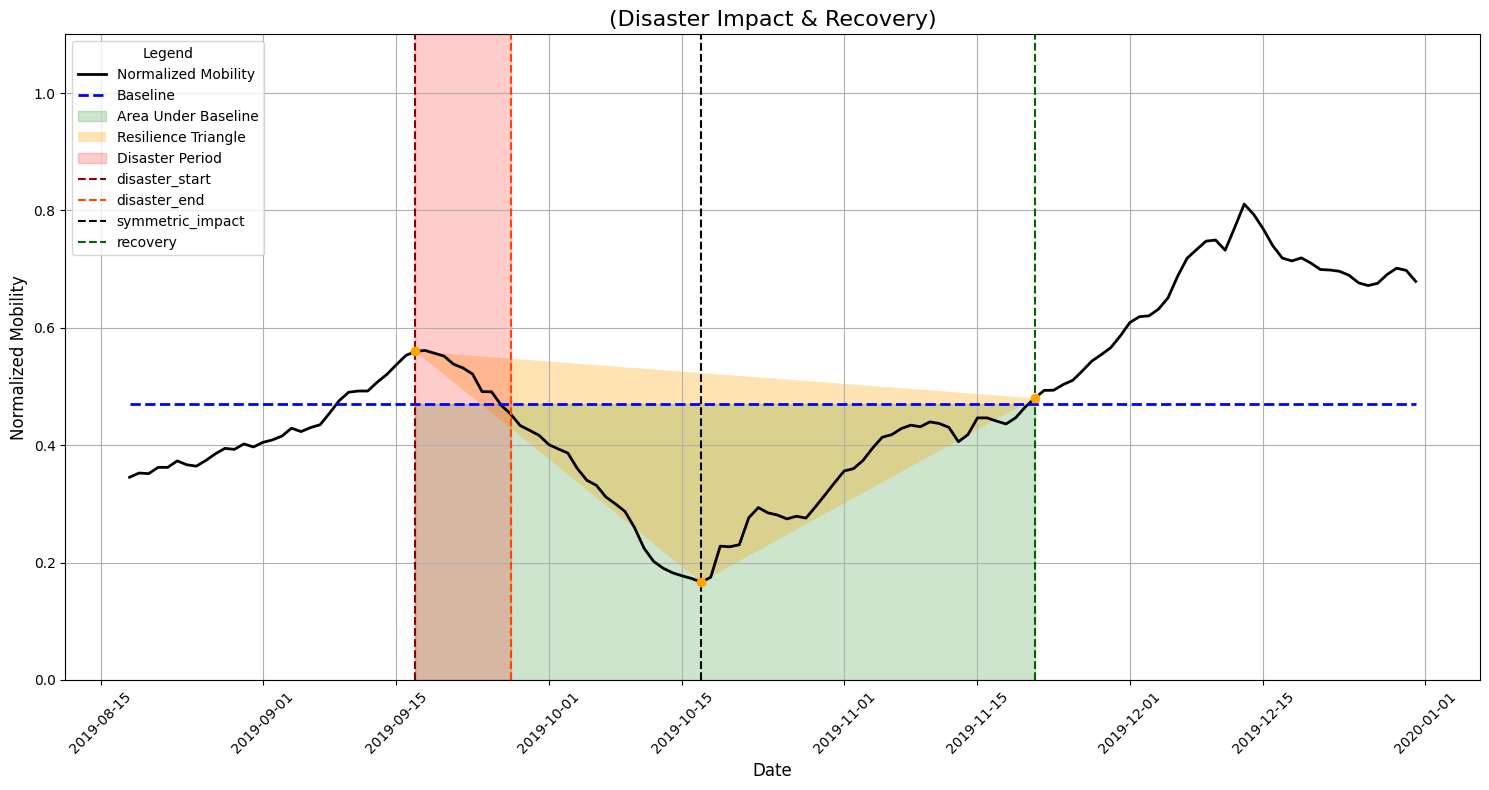

In [17]:
try:
    filtered_df = cbg_filter(df, CENSUS_BLOCK_GROUP)
    grouped_df = compute_indegree_by_destination(filtered_df)
    smoothed_df = smoothen_data(grouped_df, SMOOTHING_PERIOD)
    normal_df = normalize_data(smoothed_df)
    baseline_value = calculate_baseline(normal_df, disaster_start, BASELINE_DAYS_TO_AVERAGE_BEFORE_DISASTER)
    point_t0 = calculate_start(normal_df, disaster_start)
    point_inactive = calculate_inactive(normal_df, disaster_end)
    point_t1, recovered = calculate_recovery(normal_df, disaster_end, baseline_value)
    point_tD = calculate_systematic_impact(normal_df, baseline_value, point_t0[0], point_t1[0])
    rpoint_t0, rpoint_tD, rpoint_t1 = get_relative_points(point_t0, point_tD, point_t1)
    triangle_area = calculate_triangle_area(rpoint_t0, rpoint_tD, rpoint_t1)
    dab_area = get_area_under_baseline(baseline_value, point_t0[0], point_t1[0])
    resilience = (triangle_area/dab_area)*100
    robustness = calculate_slope(rpoint_t1, rpoint_tD)
    vulnerability = calculate_slope(rpoint_tD, rpoint_t0)

    log_summary(
        CENSUS_BLOCK_GROUP,
        DISASTER_NAME, 
        disaster_start, 
        disaster_end, 
        point_t0[0], 
        point_inactive[0], 
        point_tD[0],
        point_t1[0],
        baseline_value,
        resilience,
        robustness,
        vulnerability,
        status= "Recovered" if recovered else "Not Recovered"
        )

    plot_graph(
        df_normalized=normal_df, 
        disaster_region=[disaster_start, disaster_end],
        triangle_coordinates=[point_t0,point_tD,point_t1], 
        dab_region=[point_t0[0],point_t1[0]],
        critical_events = {
            "disaster_start": point_t0[0],
            "disaster_end": point_inactive[0], 
            "symmetric_impact": point_tD[0],
            "recovery": point_t1[0]
            },
        baseline_value = baseline_value
        ) 

except Exception as e:
    
    log_summary(
        CENSUS_BLOCK_GROUP,
        DISASTER_NAME, 
        disaster_start, 
        disaster_end, 
        point_t0[0], 
        point_inactive[0], 
        None,
        None,
        baseline_value,
        0,
        0,
        0,
        status= "No Trend Shown",
        is_special_case = True,
        message = e
        )

    plot_graph(
        df_normalized=normal_df,
        triangle_coordinates = None,
        disaster_region=[disaster_start,disaster_end], 
        dab_region = None,
        critical_events = None,
        baseline_value=baseline_value, 
        fill_dab=False, 
        critical_show=False, 
        resilience_triangle=False
        )